<a href="https://colab.research.google.com/github/tengkukevin/hwntotext/blob/main/GoogleNet-MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import BatchNormalization, Conv2D, AveragePooling2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

In [ ]:
# Load dataset MNIST
print("[INFO] Loading MNIST data...")
(train_x, train_y), (test_x, test_y) = mnist.load_data()
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

# MNIST memiliki 1 channel (grayscale), GoogLeNet butuh 3 channel, jadi perlu diubah ke RGB
train_x = np.expand_dims(train_x, axis=-1)  # Menambahkan dimensi channel
test_x = np.expand_dims(test_x, axis=-1)

# Ubah grayscale (1 channel) menjadi 3 channel (RGB)
train_x = np.repeat(train_x, 3, axis=-1)
test_x = np.repeat(test_x, 3, axis=-1)

# Resize gambar MNIST dari 28x28 ke 32x32 agar sesuai dengan GoogLeNet
train_x = tf.image.resize(train_x, [32, 32])
test_x = tf.image.resize(test_x, [32, 32])

# Convert EagerTensors to NumPy arrays [Mencegah error normalisasi data]
train_x = train_x.numpy()
test_x = test_x.numpy()

# Normalisasi data
train_x = train_x.astype("float32") / 255.0
test_x = test_x.astype("float32") / 255.0

# One-hot encoding label
train_y = to_categorical(train_y, 10)
test_y = to_categorical(test_y, 10)

mean = np.mean(train_x, axis=0)
train_x -= mean
test_x -= mean

[INFO] Loading MNIST data...
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# Definisi hyperparameter
NUM_EPOCHS = 10
INIT_LR = 5e-3
BATCH_SIZE = 64

def poly_decay(epoch):
    max_epochs = NUM_EPOCHS
    base_lr = INIT_LR
    power = 1.0
    alpha = base_lr * (1 - (epoch / float(max_epochs))) ** power
    return alpha

In [ ]:
class GoogLeNet:
    @staticmethod
    def conv_module(x, filters, kernel_size, stride, chan_dim, padding="same", reg=0.0005, name=None):
        conv_name, bn_name, act_name = (None, None, None)
        if name is not None:
            conv_name = name + "_conv"
            bn_name = name + "_bn"
            act_name = name + "_act"

        x = Conv2D(filters, kernel_size, strides=stride, padding=padding, kernel_regularizer=l2(reg), name=conv_name)(x)
        x = BatchNormalization(axis=chan_dim, name=bn_name)(x)
        x = Activation("relu", name=act_name)(x)
        return x

    @staticmethod
    def inception_module(x, num_1x1, num_3x3_reduce, num_3x3, num_5x5_reduce, num_5x5, num_1x1_proj, chan_dim, stage, reg=0.0005):
        first = GoogLeNet.conv_module(x, num_1x1, (1, 1), (1, 1), chan_dim, reg=reg, name=stage + "_first")

        second = GoogLeNet.conv_module(x, num_3x3_reduce, (1, 1), (1, 1), chan_dim, reg=reg, name=stage + "_second1")
        second = GoogLeNet.conv_module(second, num_3x3, (3, 3), (1, 1), chan_dim, reg=reg, name=stage + "_second2")

        third = GoogLeNet.conv_module(x, num_5x5_reduce, (1, 1), (1, 1), chan_dim, reg=reg, name=stage + "_third1")
        third = GoogLeNet.conv_module(third, num_5x5, (5, 5), (1, 1), chan_dim, reg=reg, name=stage + "_third2")

        fourth = MaxPooling2D((3, 3), strides=(1, 1), padding="same", name=stage + "_pool")(x)
        fourth = GoogLeNet.conv_module(fourth, num_1x1_proj, (1, 1), (1, 1), chan_dim, reg=reg, name=stage + "_fourth")

        x = concatenate([first, second, third, fourth], axis=chan_dim, name=stage + "_mixed")
        return x

    @staticmethod
    def build(width, height, depth, classes, reg=0.0005):
        input_shape = (height, width, depth)
        chan_dim = -1

        inputs = Input(shape=input_shape)

        # Initial Convolution + Pooling
        x = GoogLeNet.conv_module(inputs, 64, (5, 5), (1, 1), chan_dim, reg=reg, name="block1")
        x = MaxPooling2D((3, 3), strides=(2, 2), padding="same", name="pool1")(x)

        x = GoogLeNet.conv_module(x, 64, (1, 1), (1, 1), chan_dim, reg=reg, name="block2")
        x = GoogLeNet.conv_module(x, 192, (3, 3), (1, 1), chan_dim, reg=reg, name="block3")
        x = MaxPooling2D((3, 3), strides=(2, 2), padding="same", name="pool2")(x)

        # **Inception 3a & 3b + Pooling**
        x = GoogLeNet.inception_module(x, 64, 96, 128, 16, 32, 32, chan_dim, "3a", reg=reg)
        x = GoogLeNet.inception_module(x, 128, 128, 192, 32, 96, 64, chan_dim, "3b", reg=reg)
        x = MaxPooling2D((3, 3), strides=(2, 2), padding="same", name="pool3")(x)

        # **Inception 4a, 4b, 4c, 4d, 4e + Pooling**
        x = GoogLeNet.inception_module(x, 192, 96, 208, 16, 48, 64, chan_dim, "4a", reg=reg)
        x = GoogLeNet.inception_module(x, 160, 112, 224, 24, 64, 64, chan_dim, "4b", reg=reg)
        x = GoogLeNet.inception_module(x, 128, 128, 256, 24, 64, 64, chan_dim, "4c", reg=reg)
        x = GoogLeNet.inception_module(x, 112, 144, 288, 32, 64, 64, chan_dim, "4d", reg=reg)
        x = GoogLeNet.inception_module(x, 256, 160, 320, 32, 128, 128, chan_dim, "4e", reg=reg)
        x = MaxPooling2D((3, 3), strides=(2, 2), padding="same", name="pool4")(x)

        # **Inception 5a & 5b + Pooling**
        x = GoogLeNet.inception_module(x, 256, 160, 320, 32, 128, 128, chan_dim, "5a", reg=reg)
        x = GoogLeNet.inception_module(x, 384, 192, 384, 48, 128, 128, chan_dim, "5b", reg=reg)

        # Final layers
        x = AveragePooling2D((2, 2), name="pool5")(x)
        x = Dropout(0.4, name="do")(x)
        x = Flatten(name="flatten")(x)
        x = Dense(classes, kernel_regularizer=l2(reg), name="labels")(x)
        x = Activation("softmax", name="softmax")(x)

        model = Model(inputs, x, name="googlenet")
        return model


In [ ]:
# Compiling Model
print("[INFO] Compiling model...")
opt = SGD(learning_rate=INIT_LR, momentum=0.9)
model = GoogLeNet.build(width=32, height=32, depth=3, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# Data Augmentation
# aug = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, fill_mode="nearest")


[INFO] Compiling model...


In [ ]:
# Training Model
print("[INFO] Training model...")
history = model.fit(train_x, train_y,
                    validation_data=(test_x, test_y),
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS,
                    verbose=1)

# history = model.fit(aug.flow(train_x, train_y, batch_size=BATCH_SIZE),
#                     validation_data=(test_x, test_y),
#                     steps_per_epoch=len(train_x) // BATCH_SIZE,
#                     epochs=NUM_EPOCHS, verbose=1)

[INFO] Training model...
Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 81s 38ms/step - accuracy: 0.8335 - loss: 4.6193 - val_accuracy: 0.9766 - val_loss: 3.9859
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.9847 - loss: 3.8925 - val_accuracy: 0.9839 - val_loss: 3.6888
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.9909 - loss: 3.5999 - val_accuracy: 0.9843 - val_loss: 3.4256
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.9937 - loss: 3.3342 - val_accuracy: 0.9903 - val_loss: 3.1691
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.9939 - loss: 3.0975 - val_accuracy: 0.9840 - val_loss: 2.9684
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.9952 - loss: 2.8739 - val_accuracy: 0.9901 - val_loss: 2.7385
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.9969 - loss: 2.6642 - val_accuracy: 0.9916 - val_loss: 2.5415
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy:

In [ ]:
# Menyimpan Model
model_path = "/content/googlenet_mnist.h5"
print(f"[INFO] Saving model to {model_path}...")
model.save(model_path)

[INFO] Saving model to /content/googlenet_mnist.h5...


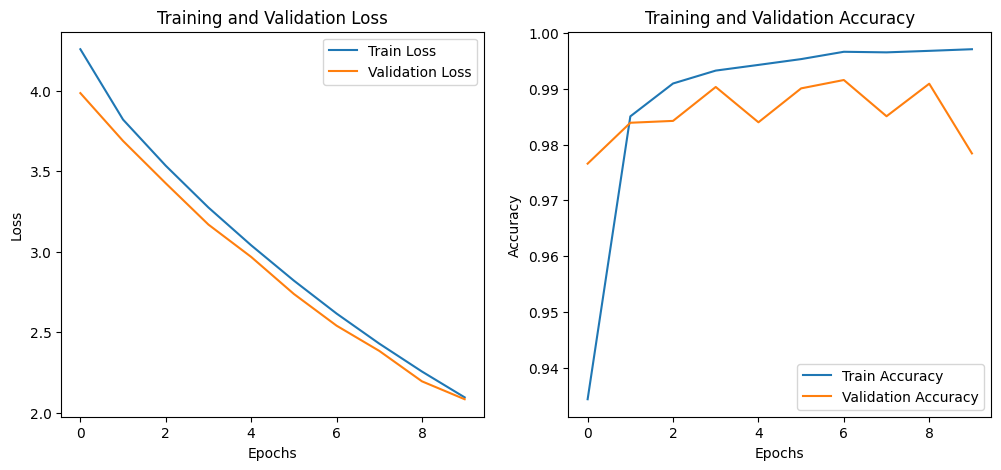

In [ ]:
import matplotlib.pyplot as plt

def plot_training(history):
       plt.figure(figsize=(12, 5))

       # Plot Loss
       plt.subplot(1, 2, 1)
       plt.plot(history.history['loss'], label='Train Loss')
       plt.plot(history.history['val_loss'], label='Validation Loss')
       plt.title('Training and Validation Loss')
       plt.xlabel('Epochs')
       plt.ylabel('Loss')
       plt.legend()

       # Plot Accuracy
       plt.subplot(1, 2, 2)
       plt.plot(history.history['accuracy'], label='Train Accuracy')
       plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
       plt.title('Training and Validation Accuracy')
       plt.xlabel('Epochs')
       plt.ylabel('Accuracy')
       plt.legend()

       plt.show()

plot_training(history)